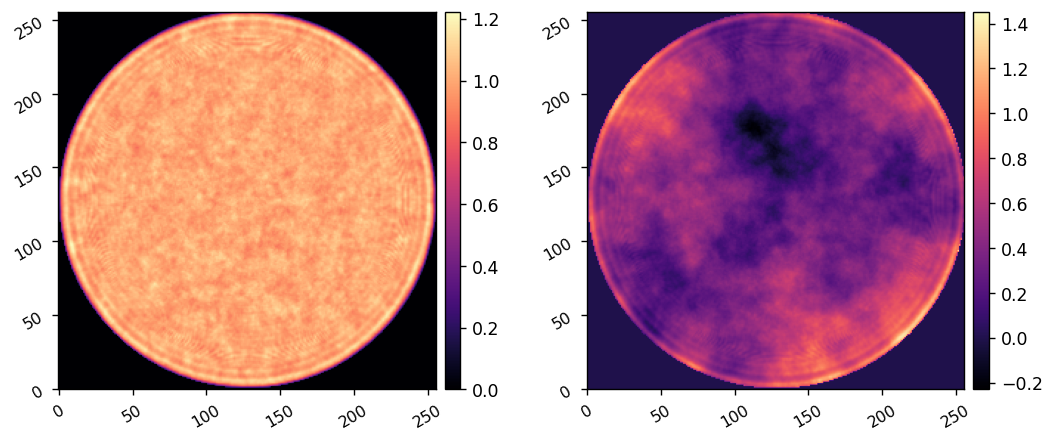

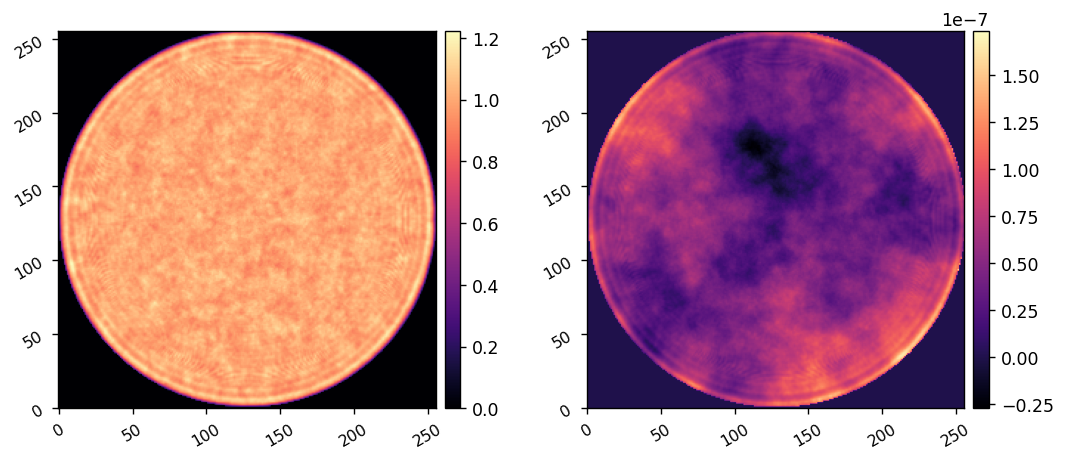

In [3]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
xp = cp if poppy.accel_math._USE_CUPY else np

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

from prop_models import compact, agpm
reload(compact)

from wfsc_1dm import utils

from imshows import *

wavelength_c = 750e-9*u.m

reload(agpm)
vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)

wfe_fits = fits.open('phase-retrieval-data/post_fpm_pupil_wfe.fits')
wfe = wfe_fits[0].data
wfe_pxscl = wfe_fits[0].header['PIXELSCL'] * u.m/u.pix
wfe_fits.close()
imshow2(wfe[0], wfe[1])

WFE = poppy.ArrayOpticalElement(transmission=wfe[0], 
                                opd=wfe[1]*wavelength_c.to_value(u.m)/(2*np.pi),
                                pixelscale=wfe_pxscl,
                               )
imshow2(WFE.amplitude, WFE.opd)

Propagating wavelength 750.000 nm.
PSF calculated in 0.411s


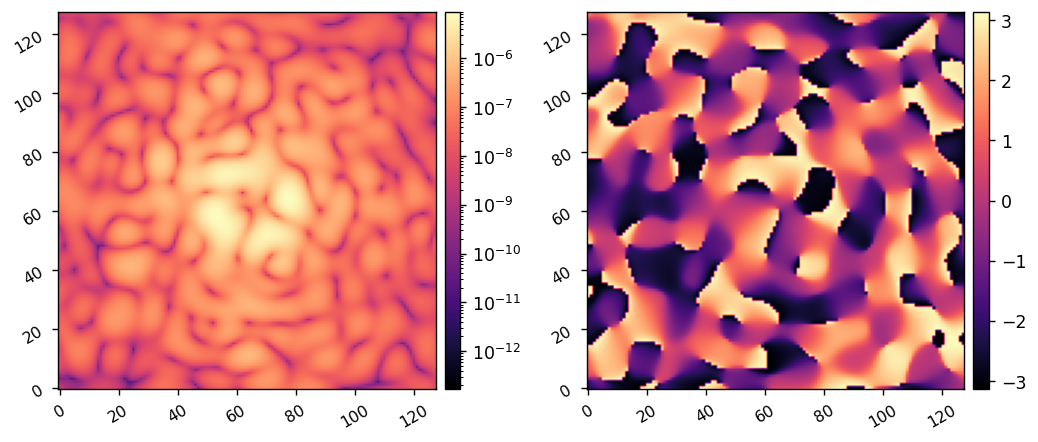

In [10]:
reload(compact)
c = compact.CORO()

c.npix = 256
c.oversample = 16
c.npsf = 128

c.reset_dm()

c.RETRIEVED = None
c.RETRIEVED = WFE

c.FPM = None
c.LYOT = None

c.FPM = vortex
c.LYOT = lyot_stop

wfs = c.calc_wfs()
imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True)

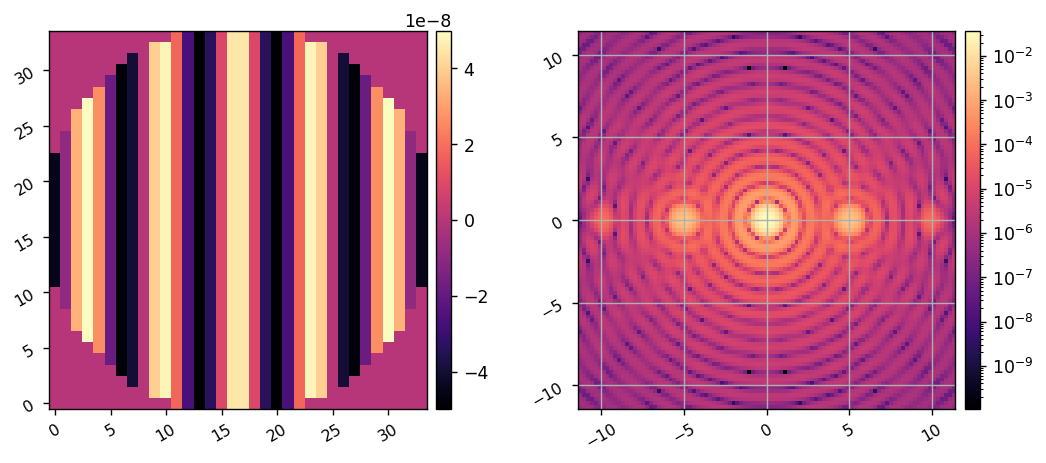

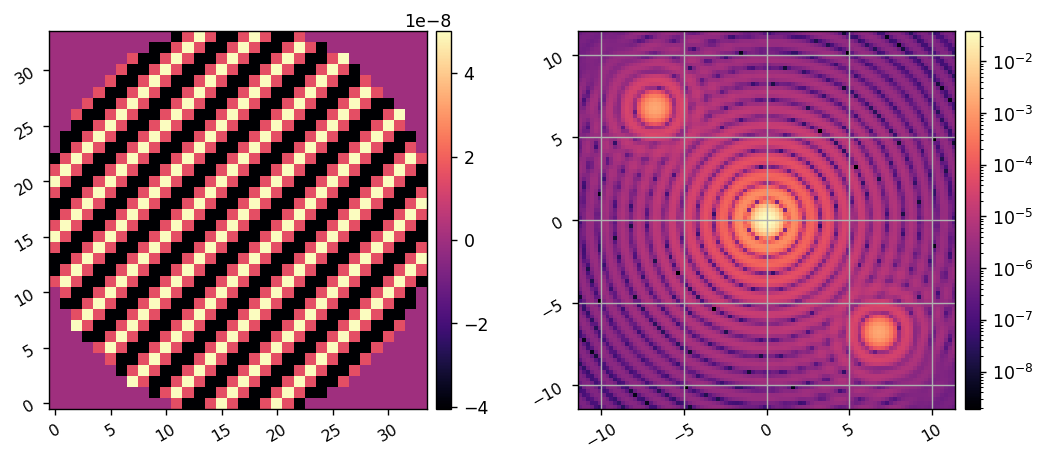

In [5]:
poppy_log.disabled = True

reload(compact)
c = compact.CORO()

Nact = c.Nact

xpp = np.linspace(-c.Nact/2, c.Nact/2-1, c.Nact) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)

separation = 5

amp = 5e-8
com_1 = amp*np.cos(2*np.pi*ppx*separation/Nact)*c.dm_mask
com_2 = amp*np.cos(2*np.pi*(ppx - ppy)/separation)*c.dm_mask

c.set_dm(com_1)
im1 = c.snap()
imshow2(c.get_dm(), im1, pxscl2=c.psf_pixelscale_lamD, lognorm2=True, grid2=True)

c.set_dm(com_2)
im2 = c.snap()
imshow2(c.get_dm(), im2, pxscl2=c.psf_pixelscale_lamD, lognorm2=True, grid2=True)